In [35]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
from sklearn.model_selection import train_test_split

In [36]:
def create_placeholders(n_x,n_y):
    X=tf.placeholder(tf.float32,shape=[n_x,None],name='X')
    Y=tf.placeholder(tf.float32,shape=[n_y,None],name='Y')
    return X,Y


In [37]:
def initialize_parameters(ld):
    w1=tf.get_variable('w1',[ld[1],ld[0]],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1=tf.get_variable('b1',[ld[1],1],initializer=tf.zeros_initializer())
    w2=tf.get_variable('w2',[ld[2],ld[1]],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2=tf.get_variable('b2',[ld[2],1],initializer=tf.zeros_initializer())
    w3=tf.get_variable('w3',[ld[3],ld[2]],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3=tf.get_variable('b3',[ld[3],1],initializer=tf.zeros_initializer())
    w4=tf.get_variable('w4',[ld[4],ld[3]],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b4=tf.get_variable('b4',[ld[4],1],initializer=tf.zeros_initializer())
    parameters={'w1':w1,'b1':b1,'w2':w2,'b2':b2,'w3':w3,'b3':b3,'w4':w4,'b4':b4}
    return parameters
    

In [38]:
def forward_propagation(X,parameters):
    w1=parameters['w1']
    b1=parameters['b1']
    w2=parameters['w2']
    b2=parameters['b2']
    w3=parameters['w3']
    b3=parameters['b3']
    w4=parameters['w4']
    b4=parameters['b4']
    z1=tf.add(tf.matmul(w1,X),b1)
    a1=tf.nn.relu(z1)
    z2=tf.add(tf.matmul(w2,a1),b2)
    a2=tf.nn.relu(z2)
    z3=tf.add(tf.matmul(w3,a2),b3)
    a3=tf.nn.relu(z3)
    z4=tf.add(tf.matmul(w4,a3),b4)
    return z4

In [39]:
def compute_cost(z3,Y):
    logits=tf.transpose(z3)
    labels=tf.transpose(Y)
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    return cost

In [40]:
def convert_to_one_hot(y,c):
    one_hot_y=tf.one_hot(y,c,axis=0)
    return one_hot_y

In [41]:
def random_mini_batches(x,y,mini_batch_size=32,seed=1):
    m=x.shape[1]
    num_total_mini_batches=m//mini_batch_size
    minibatches=[]
    perm=list(np.random.permutation(m))
    x=x[:,perm]
    y=y[:,perm]
    for i in range (num_total_mini_batches):
        minibatch_x=x[:,i*mini_batch_size:(i+1)*mini_batch_size]
        minibatch_y=y[:,i*mini_batch_size:(i+1)*mini_batch_size]
        minibatch=(minibatch_x,minibatch_y)
        minibatches.append(minibatch)
    if m%mini_batch_size!=0:
        minibatch_x=x[:,mini_batch_size*num_total_mini_batches:m]
        minibatch_y=y[:,mini_batch_size*num_total_mini_batches:m]
        minibatch=(minibatch_x,minibatch_y)
        minibatches.append(minibatch)
    return minibatches

In [42]:
def model(xtr,ytr,ld,num_epochs=50,mini_batch_size=64,learning_rate=0.001):
    n_x,m=xtr.shape
    n_y,_=ytr.shape
    tf.reset_default_graph()
    X,Y=create_placeholders(n_x,n_y)
    parameters=initialize_parameters(ld)
    z3=forward_propagation(X,parameters)
    cost=compute_cost(z3,Y)
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init=tf.global_variables_initializer()
    costs=[]
    seed=1
    with tf.Session() as sess:
        sess.run(init)
        for i in range(num_epochs):
            epoch_cost=0
            seed+=1
            num_total_mini_batches=m//mini_batch_size
            minibatches=random_mini_batches(xtr,ytr,mini_batch_size,seed)
            for minibatch in minibatches:
                (minibatch_x,minibatch_y)=minibatch
                _,c=sess.run([optimizer,cost],feed_dict={X:minibatch_x,Y:minibatch_y})
                epoch_cost+=(c/num_total_mini_batches)
            if i%10==0:
                print('epoch cost after '+str(i)+' epoches:'+str(epoch_cost))
            if i%10==0:
                costs.append(epoch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs in 10s')
        plt.title('learning rate='+str(learning_rate))
        parameters=sess.run(parameters)
    return parameters
            
            

In [43]:
def fp(x,parameters):
    w1=parameters['w1']
    b1=parameters['b1']
    w2=parameters['w2']
    b2=parameters['b2']
    w3=parameters['w3']
    b3=parameters['b3']
    w4=parameters['w4']
    b4=parameters['b4']
    z1=np.add(np.matmul(w1,x),b1)
    a1=np.maximum(z1,0)
    z2=np.add(np.matmul(w2,a1),b2)
    a2=np.maximum(z2,0)
    z3=np.add(np.matmul(w3,a2),b3)
    a3=np.maximum(z3,0)
    z4=np.add(np.matmul(w4,a3),b4)
    return z4

In [44]:
def find_accuracy(z4,labels):
    pred=(np.argmax(z4,axis=0))
    acc=np.mean(pred==labels)
    print('accuracy='+str(acc))
    return acc

In [45]:
df=pd.read_csv('./datasets/fashion-mnist_train.csv')
df1=df.as_matrix()
print(df1.shape)
ytr=df1[:,0].T.reshape(1,60000)
xtr=df1[:,1:785].T
print('x_train'+str(xtr.shape))
print('y_train'+str(ytr.shape))
ytroh=convert_to_one_hot(ytr,10)
ytroh=ytroh[:,0,:]
print('y_train_one_hot'+str(ytroh.shape))

(60000, 785)
x_train(784, 60000)
y_train(1, 60000)
y_train_one_hot(10, 60000)


In [46]:
dftest=pd.read_csv('./datasets/fashion-mnist_test.csv')
dftest1=dftest.as_matrix()
print(dftest1.shape)
yts=dftest1[:,0].T.reshape(1,10000)
xts=dftest1[:,1:785].T
print('xts shape:'+str(xts.shape))
print('yts shape:'+str(yts.shape))

(10000, 785)
xts shape:(784, 10000)
yts shape:(1, 10000)


In [83]:
classes=['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle-boot']

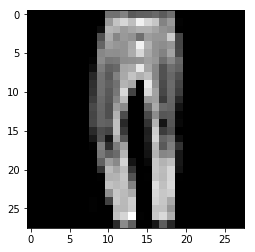

In [81]:
n=np.random.randint(0,60000)
image=xtr[:,n].reshape(28,28)
plt.imshow(image,cmap='gray')


epoch cost after 0 epoches:3.7000317793009536
epoch cost after 10 epoches:0.3833904221510814
epoch cost after 20 epoches:0.2607064566544182
epoch cost after 30 epoches:0.20690364601327108
epoch cost after 40 epoches:0.1685074568828498
epoch cost after 50 epoches:0.13740430181804278
epoch cost after 60 epoches:0.11472690143009182
epoch cost after 70 epoches:0.09730006940265269
epoch cost after 80 epoches:0.08396527455824458
epoch cost after 90 epoches:0.07545148138863325


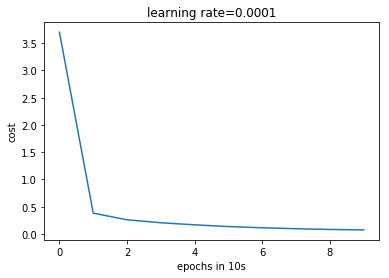

In [47]:
ld=[784,200,100,30,10]
with tf.Session() as sess:
    ytroh=ytroh.eval(session=sess)
parameters=model(xtr,ytroh,ld,100,64,0.0001)

In [48]:
z4=fp(xtr,parameters)
acc=find_accuracy(z4,ytr)
print('the train accuracy is '+str(acc))


accuracy=0.9783833333333334
the train accuracy is 0.9783833333333334


In [49]:
z4=fp(xts,parameters)
acc=find_accuracy(z4,yts)
print('the test accuracy is '+str(acc))

accuracy=0.8886
the test accuracy is 0.8886


image number:60
predicted class: coat


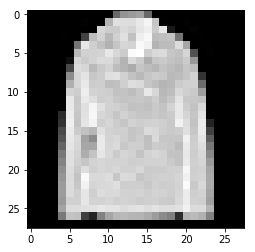

In [128]:
random_test=np.random.randint(0,10000)
print('image number:'+str(random_test))
image=xts[:,random_test].reshape(28,28)
plt.imshow(image,cmap='gray')
x=xts[:,random_test].reshape(784,1)
z3_test=fp(x,parameters)
predicted_class=classes[np.argmax(z3_test)]
print('predicted class: '+str(predicted_class))